# Start

In [1]:
import importlib
import os
import sys
import csv
import datetime 
import json
import importlib.util
import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from pathlib import Path
from docx import Document
from docx.oxml import OxmlElement
from docx.oxml.ns import qn
from docx.shared import Inches
from typing import Optional

from langchain_core.tools import Tool, StructuredTool
from langchain.agents import create_agent
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage

from bsm_multi_agents.graph.state import WorkflowState

In [2]:
cwd = Path.cwd()
project_path = cwd.parent.parent
os.chdir(project_path)
project_path

PosixPath('/Users/yifanli/Github/model_doc_automation/TooTwo_mcp')

In [3]:
server_path = os.path.join(project_path, "src/bsm_multi_agents/mcp/server.py")
csv_file_path = os.path.join(project_path, "data/input/simulated_equity_options.csv")
output_dir = os.path.join(project_path, "data/cache")
local_tool_folder_path = os.path.join(project_path, "src/bsm_multi_agents/tools")
final_report_path = os.path.join(project_path, "data/output/final_report.docx")

In [4]:
def _print_debug_summary(content: str):
    """Helper to print generated summary for debugging (simulating paragraph structure)"""
    print(f"\n{'='*80}")
    
    blocks = content.split("\n\n")
    for i, block in enumerate(blocks):
        clean_block = block.strip()
        if clean_block:
            print(f"[Paragraph {i+1}]:")
            print(clean_block)
            print("-" * 40)
            
    print(f"{'='*80}\n")

# LLM

In [6]:
from bsm_multi_agents.config import llm_config
importlib.reload(llm_config)
from bsm_multi_agents.config.llm_config import get_llm

In [7]:
llm = get_llm()

llm.invoke("Hello, how are you?")

AIMessage(content=[{'type': 'text', 'text': "Hello! I'm doing well, thank you for asking. How are you doing today? Is there anything I can help you with?", 'extras': {'signature': 'EuICCt8CAXLI2nztpT2SipZggZYMWBx/gvpxa+nw4JpD0QvDkngNrGp0/J/F049hAvMT+443V6NXzy8pJKjtTruzut4GLsrDUYc3zXuQ9E7zOGqykphM0Dx7A5+sbCs/C6JxwMcVg3uCkoGNa/Zlha5Gi4f/873JbkEmdFeMVLLqSTTQ55QZR7gXKJVOmM4FQkoKudLKlhBsDPOEnQB6/F6L3EOkT4bxZNsMnriIT3CRapOvuF5JEyLIOifoHKrjLFqIdSjELr3AfsSFUCpT5BujsXsll8C4pcgkmvXPI+4qYCTEd6Sbh/PqM0oiHSLhhymTYBpoQyZ4WJiLRYm47ZbGfRe4DR+ROMv9qohBRZwULp+WtFwUN2450323aaae8k/yJtKJjV7/X+Y8FcFgMMfYrOuNOLX2oVzTx+A2RosV9JpctueaFuJLNlRjCjhnKGzIHbwT1Nfifm7KLXrabT9ao8zi'}}], additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-3-flash-preview', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019b99ff-c1fb-7752-b2fa-ce64a3dc55a5-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 7, 'output_tokens': 112, 'total_tokens': 119, 'inpu

In [8]:
api_key = os.getenv("GOOGLE_API_KEY")
api_key

# MCP Server

## call_mcp_tool_async

In [19]:
from bsm_multi_agents.agents.mcp_adapter import call_mcp_tool

In [ ]:
server_script_path = os.path.join(project_path, "src/bsm_multi_agents/mcp/server.py")
csv_file_path = os.path.join(project_path, "data/input/simulated_equity_options.csv")
output_dir = os.path.join(project_path, "data/cache")
tool_name = "calculate_bsm_to_file"
args = {
    "input_path": csv_file_path,
    "output_dir": output_dir,
}

In [21]:
call_mcp_tool(tool_name, server_script_path, args)

CallToolResult(meta=None, content=[TextContent(type='text', text='Unknown tool: calculate_bsm_to_file', annotations=None, meta=None)], structuredContent=None, isError=True)

## list_mcp_tools_sync

In [22]:
from bsm_multi_agents.agents.mcp_adapter import list_mcp_tools_sync

In [23]:
server_script_path = os.path.join(project_path, "src/bsm_multi_agents/mcp/server.py")

In [24]:
list_mcp_tools_sync(server_script_path)

[Tool(name='calculate_greeks_to_file', title=None, description='\n    Reads the CSV at input_path, calculates greeks, and saves the result to output_dir.\n    Returns the path to the result file.\n    ', inputSchema={'properties': {'input_path': {'title': 'Input Path', 'type': 'string'}, 'output_dir': {'default': './output', 'title': 'Output Dir', 'type': 'string'}}, 'required': ['input_path'], 'title': 'calculate_greeks_to_fileArguments', 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'string'}}, 'required': ['result'], 'title': 'calculate_greeks_to_fileOutput', 'type': 'object'}, icons=None, annotations=None, meta=None),
 Tool(name='validate_greeks_to_file', title=None, description='\n    Validate Greeks for ALL options from CSV data.\n\n    For each option:\n    - Validates: BSM_price > 0\n    - Validates: delta in [0,1] for calls, [-1,0] for puts\n    - Validates: gamma >= 0, vega >= 0\n\n    Args:\n        state: InjectedState, state from the

## mcp_tool_to_langchain_tool

In [ ]:
from bsm_multi_agents.agents.mcp_adapter import list_mcp_tools_sync
server_script_path = os.path.join(project_path, "src/bsm_multi_agents/mcp/server.py")
csv_file_path = os.path.join(project_path, "data/input/simulated_equity_options.csv")
output_dir = os.path.join(project_path, "data/cache")
mcp_tools = list_mcp_tools_sync(server_script_path)
mcp_tool = mcp_tools[0]
print(mcp_tool)

name='calculate_greeks_to_file' title=None description='\n    Reads the CSV at input_path, calculates greeks, and saves the result to output_dir.\n    Returns the path to the result file.\n    ' inputSchema={'properties': {'input_path': {'title': 'Input Path', 'type': 'string'}, 'output_dir': {'default': './output', 'title': 'Output Dir', 'type': 'string'}}, 'required': ['input_path'], 'title': 'calculate_greeks_to_fileArguments', 'type': 'object'} outputSchema={'properties': {'result': {'title': 'Result', 'type': 'string'}}, 'required': ['result'], 'title': 'calculate_greeks_to_fileOutput', 'type': 'object'} icons=None annotations=None meta=None


In [26]:
from bsm_multi_agents.agents.mcp_adapter import mcp_tool_to_langchain_tool

In [27]:
test_tool = mcp_tool_to_langchain_tool(mcp_tool, server_script_path)

In [28]:
test_tool.invoke({"input_path": csv_file_path, "output_dir": output_dir})

CallToolResult(meta=None, content=[TextContent(type='text', text='/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/dummy_options_greeks_results.csv', annotations=None, meta=None)], structuredContent={'result': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/dummy_options_greeks_results.csv'}, isError=False)

# Local Tools

## load_local_tools_from_file

In [35]:
file_path = os.path.join(project_path, "src/bsm_multi_agents/tools/my_add.py")

In [38]:
module_name = os.path.basename(file_path).replace(".py", "")
spec = importlib.util.spec_from_file_location(module_name, file_path)

module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

tools = []
for name, func in inspect.getmembers(module, inspect.isfunction):
    # Exclude private functions or imports
    if not name.startswith("_") and func.__module__ == module_name:
        tools.append(StructuredTool.from_function(func))
tools
    

[StructuredTool(name='my_add', description='Add two integers.\n\nArgs:\n    a (int): The first integer.\n    b (int): The second integer.\n\nReturns:\n    int: The sum of the two integers.', args_schema=<class 'langchain_core.utils.pydantic.my_add'>, func=<function my_add at 0x11a701f80>)]

## load_local_tools_from_folder

In [41]:
from bsm_multi_agents.agents.utils import load_local_tools_from_file

In [42]:
folder_path = os.path.join(project_path, "src/bsm_multi_agents/tools")

In [44]:
tools = []
for file_name in os.listdir(folder_path):
    if file_name.endswith(".py") and file_name[0] not in "._":
        file_path = os.path.join(folder_path, file_name)
        tools.extend(load_local_tools_from_file(file_path))
tools

[StructuredTool(name='my_add', description='Add two integers.\n\nArgs:\n    a (int): The first integer.\n    b (int): The second integer.\n\nReturns:\n    int: The sum of the two integers.', args_schema=<class 'langchain_core.utils.pydantic.my_add'>, func=<function my_add at 0x11a7f2160>)]

## load_tools_from_mcp_and_local

# Tools

## calculate_option_analytics

In [4]:
csv_file_path = os.path.join(project_path, "data/input/simulated_equity_options.csv")

In [5]:
from bsm_multi_agents.mcp import option_pricer
importlib.reload(option_pricer)
from bsm_multi_agents.mcp.option_pricer import calculate_option_analytics

In [6]:
calculate_option_analytics(csv_file_path)

'/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'

## verify_put_call_parity

In [7]:
csv_file_path = os.path.join(project_path, "data/cache/analytics/analyzed_options.csv")

In [8]:
from bsm_multi_agents.mcp import test_parity
importlib.reload(test_parity)
from bsm_multi_agents.mcp.test_parity import verify_put_call_parity

In [9]:
verify_put_call_parity(csv_file_path)

'/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/put_call_parity.csv'

## Sensitivity Test

### compute_scenario_prices

In [10]:
csv_file_path = os.path.join(project_path, "data/cache/analytics/analyzed_options.csv")

In [11]:
from bsm_multi_agents.mcp import risk_analytics_engine
importlib.reload(risk_analytics_engine)
from bsm_multi_agents.mcp.risk_analytics_engine import (
    TEST_SCENARIOS,
    compute_scenario_prices,
)

In [12]:
df = pd.read_csv(csv_file_path)
compute_scenario_prices(df, TEST_SCENARIOS)

array([23.5499616 ,  9.22646685, 13.71633825, 35.53187629,  9.42775933,
       67.3009977 , 22.68377653, 20.03730962, 27.17892994, 22.31024754,
       60.55575507, 35.75647511, 22.62150811, 48.8457135 , 56.40075158,
       24.49632211, 23.18248655,  4.4570559 , 41.55522688, 13.38530857,
        1.13654533, 50.59351292, 57.02139374,  8.96541981, 52.88594736,
       78.51387572, 22.46646902, 30.02594692,  0.38148836, 64.78761349,
       24.66030137,  1.69927133, 67.0283351 , 28.30232632, 63.67283363,
       16.85855799, 10.46869167,  7.72999418, 22.62068431, 26.44514968,
       22.2371321 , 21.96499472, 18.54741935, 29.9984103 , 23.27914708,
       55.47687686, 16.77140359, 53.9269605 , 10.36264509, 37.7899535 ])

### run_sensitivity_analysis

In [19]:
csv_file_path = os.path.join(project_path, "data/cache/analytics/analyzed_options.csv")

In [20]:
from bsm_multi_agents.mcp import risk_analytics_engine
importlib.reload(risk_analytics_engine)
from bsm_multi_agents.mcp.risk_analytics_engine import (
    DEFAULT_SENSITIVITY_SCENARIOS,
    run_sensitivity_analysis,
)

In [21]:
run_sensitivity_analysis(csv_file_path)

'/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/sensitivity_test_results.csv'

## Stress Test

In [66]:
csv_file_path = os.path.join(project_path, "data/cache/analytics/analyzed_options.csv")

In [67]:
from bsm_multi_agents.mcp import risk_analytics_engine
importlib.reload(risk_analytics_engine)
from bsm_multi_agents.mcp.risk_analytics_engine import (
    DEFAULT_STRESS_SCENARIOS,
    run_stress_analysis,
)

In [68]:
run_stress_analysis(csv_file_path)

'/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/stress_test_results.csv'

## PnL Explanation

### explain_pnl_with_greeks

In [75]:
csv_file_path = os.path.join(project_path, "data/cache/analytics/stress_test_results.csv")

In [76]:
from bsm_multi_agents.mcp import risk_analytics_engine
importlib.reload(risk_analytics_engine)
from bsm_multi_agents.mcp.risk_analytics_engine import (
    compute_pnl_attribution,
    _extract_shocks,
    DEFAULT_STRESS_SCENARIOS
)

In [78]:
df = pd.read_csv(csv_file_path)

In [79]:
res = df.copy()
scenarios = DEFAULT_STRESS_SCENARIOS
scen = scenarios[0]
print(scen)

{'name': 'Black Monday (1987)', 'shocks': [{'parameter': 'S', 'type': 'relative', 'value': -0.2}, {'parameter': 'sigma', 'type': 'absolute', 'value': 0.5}, {'parameter': 'r', 'type': 'absolute', 'value': -0.005}]}


In [80]:
price_col = f"stress_scen_{scen_name}"
price_col

'stress_scen_Black Monday (1987)'

In [82]:
actual_pnl = res[price_col] - res['price']
actual_pnl

0      -0.038525
1      44.409424
2      17.487733
3      62.354692
4       7.400938
5      59.750349
6      -3.684686
7      46.670328
8       8.690391
9      35.472701
10     43.462584
11    132.705977
12      9.922351
13     59.210578
14     26.779178
15    108.589251
16     -6.598612
17     38.606331
18    -10.829645
19     41.961418
20      6.522745
21     51.350788
22     -8.367349
23     75.601917
24     28.398432
25     83.266609
26     14.490477
27     41.272147
28      2.381895
29     85.637946
30    -12.539171
31     25.203191
32     29.818624
33    114.305222
34     22.359026
35    104.077255
36     -6.264739
37     37.622348
38     20.956920
39     59.151651
40      8.882529
41     35.409768
42      9.645063
43     35.801827
44      9.682525
45     61.315156
46      7.895713
47     56.102341
48     19.726054
49     67.130280
dtype: float64

In [83]:
shocks = _extract_shocks(res, scen)
ds = shocks['S']
dv = shocks['sigma']
dr = shocks['r']

In [84]:
res[f'attr_delta_{scen_name}'] = res['delta'] * ds
res[f'attr_gamma_{scen_name}'] = 0.5 * res['gamma'] * (ds ** 2)
res[f'attr_vega_{scen_name}'] = res['vega'] * dv
res[f'attr_rho_{scen_name}'] = res['rho'] * dr

In [85]:
explained = (res[f'attr_delta_{scen_name}'] + 
                res[f'attr_gamma_{scen_name}'] + 
                res[f'attr_vega_{scen_name}'] + 
                res[f'attr_rho_{scen_name}'])

res[f'attr_unexplained_{scen_name}'] = actual_pnl - explained
res[f'attr_total_pnl_{scen_name}'] = actual_pnl

In [87]:
res.columns

Index(['ID', 'date', 'underlying', 'S', 'K', 'T', 'r', 'sigma', 'option_type',
       'style', 'asset_class', 'price', 'delta', 'gamma', 'vega', 'theta',
       'rho', 'stress_scen_Black Monday (1987)',
       'stress_scen_Dot-com Crash (2000)', 'stress_scen_2008 Financial Crisis',
       'stress_scen_VIX Spike (No Stock Move)',
       'stress_scen_Rate Shock (+200bps)', 'stress_scen_Liquidation Scenario',
       'stress_scen_Volatility Collapse', 'attr_delta_Black Monday (1987)',
       'attr_gamma_Black Monday (1987)', 'attr_vega_Black Monday (1987)',
       'attr_rho_Black Monday (1987)', 'attr_unexplained_Black Monday (1987)',
       'attr_total_pnl_Black Monday (1987)'],
      dtype='object')

In [88]:
actual_pnl - explained

0     26.877818
1     26.878486
2     31.869907
3     31.872724
4     17.394089
5     17.394539
6     20.683009
7     20.683228
8     24.320871
9     24.324088
10    94.805718
11    94.823794
12    28.942714
13    28.943928
14    77.120409
15    77.129516
16    25.124334
17    25.124658
18    24.334412
19    24.334665
20     6.042484
21     6.042797
22    53.839552
23    53.840834
24    56.541690
25    56.555076
26    28.014967
27    28.021388
28    -8.251207
29    -8.251139
30    18.878158
31    18.878280
32    83.208504
33    83.220380
34    78.481067
35    78.490444
36    13.138187
37    13.138256
38    39.244738
39    39.252408
40    23.200681
41    23.203302
42    21.837259
43    21.839608
44    29.010949
45    29.012066
46    23.195166
47    23.195887
48    31.711668
49    31.714715
dtype: float64

# Agent

## pricing_calculator_agent_node

### Inside Node

In [13]:
from bsm_multi_agents.config.llm_config import get_llm
from bsm_multi_agents.agents.utils import extract_mcp_content, load_tools_from_mcp_and_local

In [ ]:
initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path,
)
state = initial_state

In [ ]:
errors = state.get("errors", [])
"csv_file_path" not in state or not state["csv_file_path"]
server_path = state.get("server_path")

In [16]:
local_tool_folder_path = state.get("local_tool_folder_path", "")
langchain_tools = load_tools_from_mcp_and_local(server_path, local_tool_folder_path)
langchain_tools

[StructuredTool(name='calculate_option_analytics', description="Perform batch Black-Scholes pricing and Greeks calculation on a CSV file.\n\n    This tool reads a CSV, computes theoretical prices and the five major Greeks \n    (Delta, Gamma, Vega, Theta, Rho), saves the results to a new local file, \n    and returns the absolute path.\n\n    Args:\n        csv_file_path (str): Absolute path to the input CSV file. \n            Required columns:\n            - 'S': Underlying asset price (e.g., 100.50)\n            - 'K': Strike price of the option (e.g., 100.00)\n            - 'T': Time to maturity in years (e.g., 0.25 for 3 months)\n            - 'r': Annualized risk-free interest rate (e.g., 0.05 for 5%)\n            - 'sigma': Annualized volatility (e.g., 0.20 for 20%)\n            - 'option_type': Type of the option, either 'call' or 'put' (case-insensitive)\n\n    Returns:\n        str: The absolute local file path of the processed CSV containing original data \n             plus

In [19]:
llm = get_llm().bind_tools(langchain_tools)

In [20]:
system_prompt = (
    "You are a quantitative calculator agent. "
    "You have access to tools specifically for Greeks calculation via an MCP server, as well as local math tools. "
    "Use the available tools to process these requests sequentially or in parallel if appropriate. "
    "IMPORTANT: When you have completed ALL requested tasks and saved the results, you MUST output a final text response (e.g. 'Calibration and calculation complete.') with NO tool calls. This will signal the workflow to proceed."
)

user_prompt = (
    f"Input CSV File: {state['csv_file_path']}\n"
    "Please calculate the Greeks for the options in the input CSV file and save the results. "
    "Ensure you call the calculation tools."
)

# user_prompt = (
#     "Give me answer of 2 plus 4."
# )

messages = list(state.get("messages", []))
if not messages:
    messages.append(SystemMessage(content=system_prompt))
    messages.append(HumanMessage(content=user_prompt))

In [21]:
ai_msg = llm.invoke(messages)
messages.append(ai_msg)
state["messages"] = messages

In [22]:
print(f"\n>>> [Pricing Calculator Agent] Decide to use tools: {[tool['name'] for tool in ai_msg.tool_calls]}")


>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']


### Node Level

In [23]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import pricing_calculator_agent_node

In [24]:
initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path,
)

In [25]:
state = pricing_calculator_agent_node(initial_state)


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']


In [26]:
state['messages'][-1].tool_calls

[{'name': 'calculate_option_analytics',
  'args': {'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv'},
  'id': '12ecdd14-b4b5-4ba8-814d-c3ec7ff8ab66',
  'type': 'tool_call'}]

## pricing_calculator_tool_node

### Inside Node

In [27]:
from bsm_multi_agents.config.llm_config import get_llm
from bsm_multi_agents.agents.mcp_adapter import list_mcp_tools_sync

In [28]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import pricing_calculator_agent_node

initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path,
)

state = pricing_calculator_agent_node(initial_state)


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']


In [29]:
from bsm_multi_agents.agents.mcp_adapter import call_mcp_tool
from bsm_multi_agents.agents.utils import extract_mcp_content,call_local_tool,load_local_tools_from_file

In [30]:
errors = state.get("errors", [])
messages = list(state.get("messages", []))

In [31]:
last_msg = messages[-1]
not hasattr(last_msg, "tool_calls") or not last_msg.tool_calls

False

In [32]:
server_path = state.get("server_path")

In [33]:
"tool_outputs" not in state or state["tool_outputs"] is None

True

In [34]:
tool_call = last_msg.tool_calls[0]
tool_outputs_msgs = []
tool_name = tool_call["name"]
args = tool_call["args"]
call_id = tool_call["id"]
print(f">>> [Pricing Calculator Tool] Executing tool calls: {tool_name}")


>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics


In [35]:
# local_tool_paths = state.get("local_tool_paths", [])
# raw_result = call_local_tool(tool_name, args=args, local_tool_paths=local_tool_paths)
# raw_result

In [36]:
raw_result = call_mcp_tool(tool_name, server_path, args)
result_text = extract_mcp_content(raw_result)
result_text

'/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'

In [37]:
tool_outputs_msgs.append(ToolMessage(content=result_text, tool_call_id=call_id, name=tool_name))
state["current_file_path"] = result_text.strip()

In [38]:
state

{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Input CSV File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv\nPlease calculate the Greeks for the options in the input CSV file and save the results. Ensure you call the calculation tools.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-26T21:40:07.367359Z', 'done': True, 'done_reason': 'stop', 'total_duration': 19404062041, 'load_duration': 62879541, 'prompt_e

### Node Level

In [39]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)

initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path,
)

state = pricing_calculator_agent_node(initial_state)
state = pricing_calculator_tool_node(state)


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics


In [40]:
state

{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Input CSV File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv\nPlease calculate the Greeks for the options in the input CSV file and save the results. Ensure you call the calculation tools.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-26T21:42:22.713637Z', 'done': True, 'done_reason': 'stop', 'total_duration': 12659648458, 'load_duration': 73495666, 'prompt_e

## pricing_validator_agent_node

### Inside Node

In [5]:
from bsm_multi_agents.config.llm_config import get_llm
from bsm_multi_agents.agents.mcp_adapter import call_mcp_tool
from bsm_multi_agents.agents.utils import load_tools_from_mcp_and_local

In [6]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)

state = WorkflowState(
    csv_file_path=csv_file_path,
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path
)

state = pricing_calculator_agent_node(state)
state = pricing_calculator_tool_node(state)
state = pricing_calculator_agent_node(state)


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics

>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: []


In [7]:
errors = state.get("errors", [])
"current_file_path" not in state or not state["current_file_path"]

False

In [8]:
server_path = state.get("server_path")

In [9]:
local_tool_folder_path = state.get("local_tool_folder_path", "")
langchain_tools = load_tools_from_mcp_and_local(server_path, local_tool_folder_path) 
langchain_tools

[StructuredTool(name='calculate_option_analytics', description="Perform batch Black-Scholes pricing and Greeks calculation on a CSV file.\n\n    This tool reads a CSV, computes theoretical prices and the five major Greeks \n    (Delta, Gamma, Vega, Theta, Rho), saves the results to a new local file, \n    and returns the absolute path.\n\n    Args:\n        input_path (str): Absolute path to the input CSV file. \n            Required columns:\n            - 'S': Underlying asset price (e.g., 100.50)\n            - 'K': Strike price of the option (e.g., 100.00)\n            - 'T': Time to maturity in years (e.g., 0.25 for 3 months)\n            - 'r': Annualized risk-free interest rate (e.g., 0.05 for 5%)\n            - 'sigma': Annualized volatility (e.g., 0.20 for 20%)\n            - 'option_type': Type of the option, either 'call' or 'put' (case-insensitive)\n\n    Returns:\n        str: The absolute local file path of the processed CSV containing original data \n             plus co

In [11]:
llm = get_llm().bind_tools(langchain_tools)

In [12]:
system_prompt = (
    "You are a professional quantitative validator agent. "
    "Your goal is to validate option results by calling all relevant validation tools in parallel.\n\n"
    "Instructions:\n"
    "1. Analyze the input file path provided by the user.\n"
    "2. Directly call all three tools: 'verify_put_call_parity', 'run_sensitivity_analysis', and 'run_stress_analysis'.\n"
    "3. Generate all tool calls in a single turn for efficiency.\n"
    "4. **Argument Note**: For 'run_sensitivity_analysis' and 'run_stress_analysis', you MUST only provide the 'input_path' argument. Skip the 'scenarios' argument entirely to allow the functions to use their high-quality default values.\n"
    "5. You can provide a brief acknowledgement before naming the tools, but ensure the tool calls are correctly generated."
)

user_prompt = (
    f"The input CSV for validation is located at: {state['current_file_path']}\n\n"
    "Please run the following validation suite now:\n"
    "- verify_put_call_parity\n"
    "- run_sensitivity_analysis\n"
    "- run_stress_analysis"
    "do not set scenarios argument if not specified"
)

In [13]:
messages = list(state.get("messages", []))
    
# 1. Inject Task (User Prompt) IF NOT returning from a ReAct tool loop.
is_tool_return = (len(messages) > 0 and isinstance(messages[-1], ToolMessage))

if not is_tool_return:
    messages.append(HumanMessage(content=user_prompt))

# 2. Prepend System Prompt (Ephemeral)
invocation_messages = [SystemMessage(content=system_prompt)] + messages
ai_msg = llm.invoke(invocation_messages)

In [14]:
ai_msg.tool_calls

[{'name': 'verify_put_call_parity',
  'args': {'input_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': '8cb65226-982e-490b-80d0-3283599cb23a',
  'type': 'tool_call'},
 {'name': 'run_sensitivity_analysis',
  'args': {'input_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': '3ec81208-7689-4f46-9ad1-7984ba3390cd',
  'type': 'tool_call'},
 {'name': 'run_stress_analysis',
  'args': {'input_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': '5d17b272-1d35-4dc7-a9fc-f9ca80232b84',
  'type': 'tool_call'}]

### Node Level

In [5]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)


from bsm_multi_agents.agents.pricing_validator_node import (
    pricing_validator_agent_node,
)

initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path,
)

state = pricing_calculator_agent_node(initial_state)
state = pricing_calculator_tool_node(state)
state = pricing_calculator_agent_node(state)
state = pricing_validator_agent_node(state)
state


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics

>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: []

>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Agent] Loaded 6 tools: ['calculate_option_analytics', 'verify_put_call_parity', 'run_sensitivity_analysis', 'run_stress_analysis', 'PnL_attribution_analysis', 'my_add']
>>> [Pricing Validator Agent] Decide to use tools: ['verify_put_call_parity', 'run_sensitivity_analysis', 'run_stress_analysis']


{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'output_dir': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Input CSV File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv\nPlease calculate the Greeks for the options in the input CSV file and save the results. Ensure you call the calculation tools.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-26T22:20:21.715358Z', 'done': True, 'done_r

In [16]:
state['messages'][-1].tool_calls

[{'name': 'verify_put_call_parity',
  'args': {'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': '66cc5040-1772-4135-97df-0e3b9dfaad21',
  'type': 'tool_call'}]

## pricing_validator_tool_node

### Inside Node

In [15]:
from bsm_multi_agents.agents.mcp_adapter import call_mcp_tool
from bsm_multi_agents.agents.utils import extract_mcp_content, call_local_tool

In [16]:
from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)


from bsm_multi_agents.agents.pricing_validator_node import (
    pricing_validator_agent_node,
)

initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path
)

state = pricing_calculator_agent_node(initial_state)
state = pricing_calculator_tool_node(state)
state = pricing_calculator_agent_node(state)
state = pricing_validator_agent_node(state)
state


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics

>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: []

>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Agent] Decide to use tools: ['verify_put_call_parity', 'run_sensitivity_analysis', 'run_stress_analysis']


{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'output_dir': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Target File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv\nPlease calculate the option analytics (price and Greeks) for this file using the calculate_option_analytics tool.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-26T22:34:47.062856Z', 'done': True, 'done_reason': 'stop', 

In [17]:
errors = state.get("errors", [])
messages = list(state.get("messages", []))
last_msg = messages[-1]
server_path = state.get("server_path")
tool_outputs_msgs = []

In [18]:
state

{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'output_dir': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Target File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv\nPlease calculate the option analytics (price and Greeks) for this file using the calculate_option_analytics tool.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-26T22:34:47.062856Z', 'done': True, 'done_reason': 'stop', 

In [19]:
last_msg.tool_calls

[{'name': 'verify_put_call_parity',
  'args': {'input_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': 'fdb5c300-fffd-4e1a-ad83-95c8830520ce',
  'type': 'tool_call'},
 {'name': 'run_sensitivity_analysis',
  'args': {'input_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': '8f143c70-2ebc-4dcc-92eb-fb8d6ee77d7f',
  'type': 'tool_call'},
 {'name': 'run_stress_analysis',
  'args': {'input_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/analyzed_options.csv'},
  'id': '4774c00c-de8c-4d5f-b825-6bcac9a0f5b7',
  'type': 'tool_call'}]

In [20]:
tool_call = last_msg.tool_calls[0]
tool_name = tool_call["name"]
args = tool_call["args"]
call_id = tool_call["id"]
print(f">>> [Pricing Validator Tool] Executing tool calls: {tool_name}")


>>> [Pricing Validator Tool] Executing tool calls: verify_put_call_parity


In [22]:
# local_tool_paths = state.get("local_tool_paths", [])
# raw_result = call_local_tool(tool_name, args=args, local_tool_paths=local_tool_paths)
# result_text = str(raw_result)

In [21]:
raw_result = call_mcp_tool(tool_name, server_path, args)
result_text = extract_mcp_content(raw_result)
result_text

'/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/put_call_parity.csv'

In [22]:
for tool_call in last_msg.tool_calls:
    tool_name = tool_call["name"]
    args = tool_call["args"]
    call_id = tool_call["id"]
    print(f">>> [Pricing Validator Tool] Executing tool calls: {tool_name}")
    
    try:
        # 1. Try Local Tool First
        local_tool_paths = state.get("local_tool_paths", [])
        try:
            raw_result = call_local_tool(tool_name, args=args, local_tool_paths=local_tool_paths)
            result_text = str(raw_result)
        except LookupError:
            # 2. Fallback to MCP Tool
            # print(f"Tool {tool_name} not found locally, trying MCP...")
            raw_result = call_mcp_tool(tool_name, server_path, args)
            result_text = extract_mcp_content(raw_result)
            print(result_text)
        
        # Create ToolMessage
        tool_outputs_msgs.append(ToolMessage(content=result_text, tool_call_id=call_id, name=tool_name))
        
        # Generic Output Handling
        state["current_file_path"] = result_text.strip()

    except Exception as e:
        err_msg = f"Error executing {tool_name}: {e}"
        errors.append(err_msg)
        tool_outputs_msgs.append(ToolMessage(content=err_msg, tool_call_id=call_id, is_error=True))
            

>>> [Pricing Validator Tool] Executing tool calls: verify_put_call_parity
/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/put_call_parity.csv
>>> [Pricing Validator Tool] Executing tool calls: run_sensitivity_analysis
/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/sensitivity_test_results.csv
>>> [Pricing Validator Tool] Executing tool calls: run_stress_analysis
/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/stress_test_results.csv


In [25]:
tool_outputs_msgs

[ToolMessage(content='/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache/analytics/put_call_parity.csv', name='verify_put_call_parity', tool_call_id='66cc5040-1772-4135-97df-0e3b9dfaad21')]

In [26]:
state

{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv',
 'output_dir': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Input CSV File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/simulated_equity_options.csv\nPlease calculate the Greeks for the options in the input CSV file and save the results. Ensure you call the calculation tools.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-26T21:59:54.725649Z', 'done': True, 'done_r

### Node Level

In [23]:
server_path = os.path.join(project_path, "src/bsm_multi_agents/mcp/server.py")
csv_file_path = os.path.join(project_path, "data/input/dummy_options.csv")
output_dir = os.path.join(project_path, "data/cache")
local_tool_folder_path = os.path.join(project_path, "src/bsm_multi_agents/tools")
final_report_path = os.path.join(project_path, "data/output/final_report.docx")

from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)

from bsm_multi_agents.agents import pricing_validator_node
importlib.reload(pricing_validator_node)
from bsm_multi_agents.agents.pricing_validator_node import (
    pricing_validator_agent_node,
    pricing_validator_tool_node,
)

initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path
)

state = pricing_calculator_agent_node(initial_state)
state = pricing_calculator_tool_node(state)
state = pricing_calculator_agent_node(state)
state = pricing_validator_agent_node(state)
state = pricing_validator_tool_node(state)
state = pricing_validator_agent_node(state)
state


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_option_analytics']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_option_analytics

>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: []

>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Agent] Decide to use tools: ['verify_put_call_parity', 'run_sensitivity_analysis', 'run_stress_analysis']

>>> [Pricing Validator Tool] Executing validation calls...
>>> [Pricing Validator Tool] Executing tool calls: verify_put_call_parity
>>> [Pricing Validator Tool] Executing tool calls: run_sensitivity_analysis
>>> [Pricing Validator Tool] Executing tool calls: run_stress_analysis

>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Agent] Decide to use tools: []


{'csv_file_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/dummy_options.csv',
 'output_dir': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache',
 'server_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/mcp/server.py',
 'local_tool_folder_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/src/bsm_multi_agents/tools',
 'final_report_path': '/Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx',
 'messages': [HumanMessage(content='Target File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/dummy_options.csv\nPlease calculate the option analytics (price and Greeks) for this file using the calculate_option_analytics tool.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:32b', 'created_at': '2026-01-26T22:39:58.995989Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1831

In [29]:
state = pricing_validator_agent_node(state)
state = pricing_validator_tool_node(state)


>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Agent] Decide to use tools: ['run_sensitivity_analysis']

>>> [Pricing Validator Tool] Executing validation calls...
>>> [Pricing Validator Tool] Executing tool calls: run_sensitivity_analysis


In [30]:
state = pricing_validator_agent_node(state)
state = pricing_validator_tool_node(state)


>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Agent] Decide to use tools: ['run_sensitivity_analysis']

>>> [Pricing Validator Tool] Executing validation calls...
>>> [Pricing Validator Tool] Executing tool calls: run_sensitivity_analysis


In [ ]:
state = pricing_validator_agent_node(state)
state = pricing_validator_tool_node(state)

## report_generator_node

### Inside Node

In [14]:
from bsm_multi_agents.config.llm_config import get_llm
from bsm_multi_agents.agents.report_generator_node import (
    _add_title_page,
    _add_section_1,
    _generate_pricing_summary,
    _generate_gamma_summary,
    _generate_stress_test_summary,
)

In [6]:
print("\n>>> [Report Generator Agent] Compiling final report...")

## Load parameters
errors = state.get("errors", [])
csv_file_path = state.get("csv_file_path")
output_dir = state.get("output_dir")

p = Path(csv_file_path)
pricing_results_path = f"{output_dir}/{p.stem}_greeks_results{p.suffix}"
validate_results_path = f"{output_dir}/{p.stem}_greeks_results_validate_results{p.suffix}"
stress_test_results_path = f"{output_dir}/{p.stem}_greeks_results_stress_test_results{p.suffix}"
gamma_positivity_test_results_path = f"{output_dir}/{p.stem}_greeks_results_gamma_positivity_test_results{p.suffix}"
final_report_path = state.get("final_report_path")

# Load DataFrames
df_pricing = pd.read_csv(pricing_results_path)
stress_test_results = pd.read_csv(stress_test_results_path)
gamma_positivity_test_results = pd.read_csv(gamma_positivity_test_results_path)

## Set parameters
report_params = {
    "title": "Ongoing Monitoring Analysis Report",
    "model_name": "Option Pricing, BSM",
    "author_name": "John Doe",
    "group_name": "Front Desk Modeling and Analytics",
    "version": "v1.0"
}


llm = get_llm()
doc = Document()

# 1. Title Page
print(">>>>>> [Report Generator Agent] Compiling title page...")
_add_title_page(doc, report_params)

# 2. Section 1
print(">>>>>> [Report Generator Agent] Compiling section 1...")
_add_section_1(doc, "1. Introduction", None)

# 3. Section 2 (Loop per asset)
print(">>>>>> [Report Generator Agent] Compiling section 2...")
doc.add_heading("2. Summary of Analysis", level=1)

section_ordering = 0
# Assuming df_pricing has asset_class column. If not present in all rows, might crash.
# We loop specific assets as per original code.
for asset in ["FX", "Equity", "Commodity"]:
    section_ordering += 1
    print(f">>>>>>>>> [Report Generator Agent] Compiling section 2.{section_ordering}: {asset}...")

    df_pricing_sub = df_pricing[df_pricing["asset_class"] == asset]
    df_gamma_positivity_test_results_sub = gamma_positivity_test_results[gamma_positivity_test_results["asset_class"] == asset]
    df_stress_test_results_sub = stress_test_results[stress_test_results["asset_class"] == asset]
    
    print(f">>>>>>>>>>>> [Report Generator Agent] Compiling section 2.{section_ordering}: {asset} pricing summary...")
    _generate_pricing_summary(doc, llm, asset, df_pricing_sub, section_ordering)
    
    print(f">>>>>>>>>>>> [Report Generator Agent] Compiling section 2.{section_ordering}: {asset} gamma positivity summary...")
    _generate_gamma_summary(doc, llm, asset, df_gamma_positivity_test_results_sub, section_ordering)
    
    print(f">>>>>>>>>>>> [Report Generator Agent] Compiling section 2.{section_ordering}: {asset} stress test summary...")
    _generate_stress_test_summary(doc, llm, asset, df_stress_test_results_sub, section_ordering)

doc.save(final_report_path)


>>> [Report Generator Agent] Compiling final report...
>>>>>> [Report Generator Agent] Compiling title page...
>>>>>> [Report Generator Agent] Compiling section 1...
>>>>>> [Report Generator Agent] Compiling section 2...
>>>>>>>>> [Report Generator Agent] Compiling section 2.1: FX...
>>>>>>>>>>>> [Report Generator Agent] Compiling section 2.1: FX pricing summary...
>>>>>>>>>>>> [Report Generator Agent] Compiling section 2.1: FX gamma positivity summary...
>>>>>>>>>>>> [Report Generator Agent] Compiling section 2.1: FX stress test summary...
>>>>>>>>> [Report Generator Agent] Compiling section 2.2: Equity...
>>>>>>>>>>>> [Report Generator Agent] Compiling section 2.2: Equity pricing summary...
>>>>>>>>>>>> [Report Generator Agent] Compiling section 2.2: Equity gamma positivity summary...
>>>>>>>>>>>> [Report Generator Agent] Compiling section 2.2: Equity stress test summary...
>>>>>>>>> [Report Generator Agent] Compiling section 2.3: Commodity...
>>>>>>>>>>>> [Report Generator Agent] C

#### _add_title_page

#### _add_section_1

#### _generate_pricing_summary

In [62]:
from bsm_multi_agents.config import llm_config
importlib.reload(llm_config)
from bsm_multi_agents.config.llm_config import get_llm

In [63]:
server_path = os.path.join(project_path, "src/bsm_multi_agents/mcp/server.py")
csv_file_path = os.path.join(project_path, "data/input/dummy_options.csv")
output_dir = os.path.join(project_path, "data/cache")
local_tool_folder_path = os.path.join(project_path, "src/bsm_multi_agents/tools")
final_report_path = os.path.join(project_path, "data/output/final_report.docx")

state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path
)

errors = state.get("errors", [])
csv_file_path = state.get("csv_file_path")
output_dir = state.get("output_dir")

p = Path(csv_file_path)
pricing_results_path = f"{output_dir}/{p.stem}_greeks_results{p.suffix}"
validate_results_path = f"{output_dir}/{p.stem}_greeks_results_validate_results{p.suffix}"
sensitivity_test_results_path = f"{output_dir}/{p.stem}_sensitivity_test_results{p.suffix}"
gamma_positivity_test_results_path = f"{output_dir}/{p.stem}_gamma_positivity_test_results{p.suffix}"
final_report_path = state.get("final_report_path")

# Load DataFrames
df_pricing = pd.read_csv(pricing_results_path)
sensitivity_test_results = pd.read_csv(sensitivity_test_results_path)
gamma_positivity_test_results = pd.read_csv(gamma_positivity_test_results_path)

## Set parameters
report_params = {
    "title": "Ongoing Monitoring Analysis Report",
    "model_name": "Option Pricing, BSM",
    "author_name": "John Doe",
    "group_name": "Front Desk Modeling and Analytics",
    "version": "v1.0"
}


llm = get_llm()

In [32]:
asset = 'FX'
df_pricing_sub = df_pricing[df_pricing["asset_class"] == asset]
df_gamma_positivity_test_results_sub = gamma_positivity_test_results[gamma_positivity_test_results["asset_class"] == asset]
df_sensitivity_test_results_sub = sensitivity_test_results[sensitivity_test_results["asset_class"] == asset]

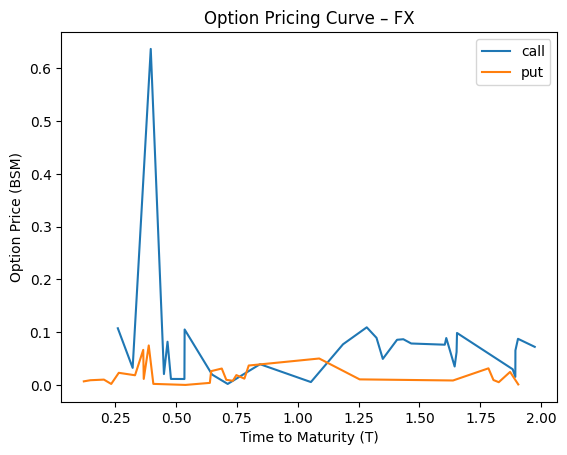

In [33]:
df = df_pricing_sub.sort_values("T").dropna(subset=['BSM_price','T'])
df_call = df[df["option_type"] == "call"]
df_put = df[df["option_type"] == "put"]

# Generate Plot
fig, ax = plt.subplots()
ax.plot(df_call["T"], df_call["BSM_price"], label="call")
ax.plot(df_put["T"], df_put["BSM_price"], label="put")
ax.set_xlabel("Time to Maturity (T)")
ax.set_ylabel("Option Price (BSM)")
ax.set_title(f"Option Pricing Curve – {asset}")  
ax.legend()

plt.show()


In [34]:
df_call.head()

,ID,date,S,K,T,r,sigma,option_type,asset_class,BSM_price,delta,gamma,vega,rho,theta,error
81,82,2025-09-22,1.112184,1.019061,0.261192,0.049466,0.120624,call,FX,0.107623,0.951429,1.469824,0.057281,0.248273,-0.060246,NaN
141,142,2025-09-22,1.183822,1.213237,0.322106,0.047593,0.140647,call,FX,0.032636,0.469902,4.209734,0.267275,0.168669,-0.083274,NaN
0,1,2025-09-01,1.124836,1.147031,0.396435,0.016240,2.500000,call,FX,0.636560,0.781926,0.166386,0.208645,0.096326,-0.661824,NaN
115,116,2025-09-26,1.110699,1.165847,0.450590,0.018374,0.130620,call,FX,0.020954,0.339287,3.759419,0.272964,0.160361,-0.046103,NaN
111,112,2025-09-22,1.053006,0.983996,0.465349,0.011635,0.116756,call,FX,0.082160,0.831180,3.003814,0.180964,0.369058,-0.031929,NaN


In [ ]:
# system_prompt = (
#     "You are a Strict Data Analyst. Analyze the provided option pricing JSON data (Cols: ID, Date, S, K, T, r, sigma, option_type, asset_class, BSM_price) and produce a professional 5-section report:\n\n"
#     "1. **Overall Data Quality**: Count Calls/Puts. Check for missing values, outliers (negative price), and logic (Call<=S, Put<=K, T>0).\n"
#     "2. **Pricing Level**: Analyze Moneyness (S/K) and Volatility levels.\n"
#     "3. **Term Structure**: Describe Theta (price vs T) and Volatility Term Structure.\n"
#     "4. **Call vs Put Behavior**: Compare prices and check for observable Skew.\n"
#     "5. **Key Takeaway**: Summarize data reliability, market regime (high/low vol), anomalies, and potential strategies.\n\n"
#     "Keep it concise and strictly follow these 5 sections."
# )
# user_prompt = (
#     f"Analyze **{asset}** options:\n\n"
#     "**Calls (JSON):**\n"
#     f"{df_call}\n\n"
#     "**Puts (JSON):**\n"
#     f"{df_put}\n\n"
#     "Generate the report."
# )


system_prompt = (
    "Please summmarize the option pricing results (pull and call) from the tables with the following topics"
    "1. Overall Data Quality"
    "2. Pricing Level by Asset Class"
    "3. Term Structure (Price vs Maturity)"
    "4. Call vs Put Behavior"
    "5. Model Consistency"
    "6. Key Takeaway"
    "Also, we have some annotation for you to understand table columns"
    "The data will contain the following columns:\n"
    "- **Date:** The date on which the option price is calculated.\n"
    "- **S:** Current price of the underlying asset.\n"
    "- **K:** Exercise price of the option.\n"
    "- **T:** Time remaining until option expiration, expressed in years.\n"
    "- **r:** Annualized risk-free interest rate, used for discounting.\n"
    "- **sigma:** Annualized standard deviation of the underlying asset’s returns.\n"
    "- **option_type:** Call or Put.\n"
    "- **asset_class:** Classification of the underlying asset (e.g., equity, index).\n"
    "- **BSM_price:** Option price calculated using the Black-Scholes-Merton model.\n"
    "- **error:** Error when calculating the BSM price.\n"
)

user_prompt = (
    "Here is the raw pull and call price tables that should become the option pricing output summary section. The title should have this asset class name."
    "Please refine it as described:\n\n"
    f"{df}"
)


In [60]:
ai_msg = llm.invoke([
    SystemMessage(content=system_prompt),
    HumanMessage(content=user_prompt)
])

In [61]:
_print_debug_summary(ai_msg.content)


[Paragraph 1]:
# FX Option Pricing Summary
----------------------------------------
[Paragraph 2]:
## 1. Overall Data Quality
The data quality appears to be high, with no missing values in the key columns. However, the error column for the Black-Scholes-Merton (BSM) price calculations is filled with NaN values, indicating that the error metrics were not computed or are not available for the options analyzed.
----------------------------------------
[Paragraph 3]:
## 2. Pricing Level by Asset Class
The pricing levels for both call and put options in the FX asset class show a range of values. Call options have BSM prices ranging from approximately 0.0022 to 0.6366, while put options range from about 0.0013 to 0.0751. This indicates a generally lower pricing level for put options compared to call options, which is typical in FX markets.
----------------------------------------
[Paragraph 4]:
## 3. Term Structure (Price vs Maturity)
The term structure analysis reveals that as the time to 

In [55]:
[df_call.shape, df_put.shape]

[(29, 16), (27, 16)]

#### _generate_gamma_summary

In [70]:
from bsm_multi_agents.config import llm_config
importlib.reload(llm_config)
from bsm_multi_agents.config.llm_config import get_llm

In [71]:
server_path = os.path.join(project_path, "src/bsm_multi_agents/mcp/server.py")
csv_file_path = os.path.join(project_path, "data/input/dummy_options.csv")
output_dir = os.path.join(project_path, "data/cache")
local_tool_folder_path = os.path.join(project_path, "src/bsm_multi_agents/tools")
final_report_path = os.path.join(project_path, "data/output/final_report.docx")

state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path
)

errors = state.get("errors", [])
csv_file_path = state.get("csv_file_path")
output_dir = state.get("output_dir")

p = Path(csv_file_path)
pricing_results_path = f"{output_dir}/{p.stem}_greeks_results{p.suffix}"
validate_results_path = f"{output_dir}/{p.stem}_greeks_results_validate_results{p.suffix}"
sensitivity_test_results_path = f"{output_dir}/{p.stem}_sensitivity_test_results{p.suffix}"
gamma_positivity_test_results_path = f"{output_dir}/{p.stem}_gamma_positivity_test_results{p.suffix}"
final_report_path = state.get("final_report_path")

# Load DataFrames
df_pricing = pd.read_csv(pricing_results_path)
sensitivity_test_results = pd.read_csv(sensitivity_test_results_path)
gamma_positivity_test_results = pd.read_csv(gamma_positivity_test_results_path)

## Set parameters
report_params = {
    "title": "Ongoing Monitoring Analysis Report",
    "model_name": "Option Pricing, BSM",
    "author_name": "John Doe",
    "group_name": "Front Desk Modeling and Analytics",
    "version": "v1.0"
}


llm = get_llm()

In [72]:
asset = 'FX'
df_pricing_sub = df_pricing[df_pricing["asset_class"] == asset]
df_gamma_positivity_test_results_sub = gamma_positivity_test_results[gamma_positivity_test_results["asset_class"] == asset]
df_sensitivity_test_results_sub = sensitivity_test_results[sensitivity_test_results["asset_class"] == asset]

df = df_gamma_positivity_test_results_sub

In [73]:
system_prompt = (
    "Please summarize the gamma positivity results from the tables with only summarizing quantitative statistics and quantitative explanation into two paragraphs."
    "Also, we have some annotation for you to understand table columns"
    "Parameters:"
    "option_type (str): 'call' for call option, 'put' for put option"
    "S (float): current stock price"
    "K (float): option strike price"
    "T (float): time to expiration in years"
    "r (float): risk-free interest rate (annualized)"
    "sigma (float): volatility of the underlying stock (annualized)"
    "gamma_positivity: True if gamma positivity holds, False otherwise"
)
user_prompt = (
    "Here is the raw testing result tables that should become the option pricing output gamma positivity testing summary section."
    "The title should have this asset class name."
    "Please refine it as described:\n\n"
    f"{df}"
)



In [74]:
ai_msg = llm.invoke([
    SystemMessage(content=system_prompt),
    HumanMessage(content=user_prompt)
])

In [76]:
_print_debug_summary(ai_msg.content)


[Paragraph 1]:
**Gamma Positivity Testing Summary for FX Options**
----------------------------------------
[Paragraph 2]:
The dataset includes 64 FX options (38 calls and 26 puts) tested for gamma positivity. All 64 options (100%) exhibited gamma positivity, with no instances of negative gamma. The parameters spanned a wide range: stock prices (S) from 1.029 to 1.172, strike prices (K) from 0.936 to 1.203, time to expiration (T) from 0.332 to 1.894 years, risk-free rates (r) from 1.16% to 3.46%, and volatilities (σ) from 0.072 to 2.500. Notably, 12 options had volatilities exceeding 0.15, yet all maintained gamma positivity, indicating robustness across varying volatility levels.
----------------------------------------
[Paragraph 3]:
Quantitatively, 56.25% of options (36/64) had time to expiration under 1 year, while 43.75% (28/64) extended beyond 1 year. The average gamma positivity rate was 100% for both call and put options, with 59.38% (38/64) of calls and 40.62% (26/64) of puts

In [78]:
[df.shape]

[(64, 10)]

#### _generate_sensitivity_test_summary

In [ ]:
from bsm_multi_agents.config import llm_config
importlib.reload(llm_config)
from bsm_multi_agents.config.llm_config import get_llm

In [ ]:
server_path = os.path.join(project_path, "src/bsm_multi_agents/mcp/server.py")
csv_file_path = os.path.join(project_path, "data/input/dummy_options.csv")
output_dir = os.path.join(project_path, "data/cache")
local_tool_folder_path = os.path.join(project_path, "src/bsm_multi_agents/tools")
final_report_path = os.path.join(project_path, "data/output/final_report.docx")

state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path
)

errors = state.get("errors", [])
csv_file_path = state.get("csv_file_path")
output_dir = state.get("output_dir")

p = Path(csv_file_path)
pricing_results_path = f"{output_dir}/{p.stem}_greeks_results{p.suffix}"
validate_results_path = f"{output_dir}/{p.stem}_greeks_results_validate_results{p.suffix}"
sensitivity_test_results_path = f"{output_dir}/{p.stem}_sensitivity_test_results{p.suffix}"
gamma_positivity_test_results_path = f"{output_dir}/{p.stem}_gamma_positivity_test_results{p.suffix}"
final_report_path = state.get("final_report_path")

# Load DataFrames
df_pricing = pd.read_csv(pricing_results_path)
sensitivity_test_results = pd.read_csv(sensitivity_test_results_path)
gamma_positivity_test_results = pd.read_csv(gamma_positivity_test_results_path)

## Set parameters
report_params = {
    "title": "Ongoing Monitoring Analysis Report",
    "model_name": "Option Pricing, BSM",
    "author_name": "John Doe",
    "group_name": "Front Desk Modeling and Analytics",
    "version": "v1.0"
}


llm = get_llm()

asset = 'FX'
df_pricing_sub = df_pricing[df_pricing["asset_class"] == asset]
df = gamma_positivity_test_results[gamma_positivity_test_results["asset_class"] == asset]
df_sensitivity = sensitivity_test_results[sensitivity_test_results["asset_class"] == asset]

In [ ]:
sensitivity_results_call = df_sensitivity[
    (df_sensitivity['option_type'] == 'call')
]
sensitivity_results_put = df_sensitivity[
    (df_sensitivity['option_type'] == 'put')
]



In [32]:
stress_results_call.columns

Index(['date', 'S', 'K', 'T', 'r', 'sigma', 'option_type', 'asset_class',
       'BSM_price', 'delta', 'gamma', 'vega', 'rho', 'theta', 'error',
       'base_price', 'Black Monday (1987)_spot_change_pct',
       'Black Monday (1987)_vol_change_pct',
       'Black Monday (1987)_rate_change_pct',
       'Black Monday (1987)_stressed_price', 'Black Monday (1987)_PnL',
       'Black Monday (1987)_PnL%', 'Dot-com Crash (2000)_spot_change_pct',
       'Dot-com Crash (2000)_vol_change_pct',
       'Dot-com Crash (2000)_rate_change_pct',
       'Dot-com Crash (2000)_stressed_price', 'Dot-com Crash (2000)_PnL',
       'Dot-com Crash (2000)_PnL%', '2008 Financial Crisis_spot_change_pct',
       '2008 Financial Crisis_vol_change_pct',
       '2008 Financial Crisis_rate_change_pct',
       '2008 Financial Crisis_stressed_price', '2008 Financial Crisis_PnL',
       '2008 Financial Crisis_PnL%',
       'VIX Spike (No Stock Move)_spot_change_pct',
       'VIX Spike (No Stock Move)_vol_change_pct',
  

In [ ]:
system_prompt = (
    "You are a Risk Manager analyzing stress test results for an option portfolio. "
    "The provided data contains P&L impact (as % of price) under various historical and hypothetical extreme scenarios "
    "(e.g., 'Black Monday (1987)', '2008 Financial Crisis').\n"
    "Your task is to summarize the portfolio's resilience and vulnerabilities.\n"
    "Focus on:\n"
    "1. **Worst-Case Scenarios**: Which scenario causes the largest loss for Calls vs Puts?\n"
)
user_prompt = (
    f"Here are the stress test results for **{asset}** options.\n"
    "The table includes columns like '{Scenario}_PnL%' and 'worst_case_pnl_pct'.\n\n"
    "**Call Options Data:**\n"
    f"{stress_results_call.to_markdown(index=False)}\n\n"
    "**Put Options Data:**\n"
    f"{stress_results_put.to_markdown(index=False)}\n\n"
    "Please provide a concise risk summary, analyzing the Call and Put profiles separately if their risk sensitivities differ significantly."
)

In [35]:
ai_msg = llm.invoke([
    SystemMessage(content=system_prompt),
    HumanMessage(content=user_prompt)
])

In [36]:
def _print_debug_summary(content: str):
    """Helper to print generated summary for debugging (simulating paragraph structure)"""
    print(f"\n{'='*80}")
    
    blocks = content.split("\n\n")
    for i, block in enumerate(blocks):
        clean_block = block.strip()
        if clean_block:
            print(f"[Paragraph {i+1}]:")
            print(clean_block)
            print("-" * 40)
            
    print(f"{'='*80}\n")

_print_debug_summary(ai_msg.content[0]['text'])


[Paragraph 1]:
This Risk Management report summarizes the stress test results for the FX options portfolio, focusing on the Call and Put profiles.
----------------------------------------
[Paragraph 2]:
### 1. Worst Case Scenario Analysis
----------------------------------------
[Paragraph 3]:
*   **Call Options:**
    *   **Primary Threat:** The **Dot-com Crash (2000)** and **Volatility Collapse** are the most damaging.
    *   **Historical:** The Dot-com Crash scenario (Spot -70%) causes losses ranging from **-57% to -61%** for deep-in-the-money or long-dated calls.
    *   **Hypothetical:** The **Volatility Collapse** (-50% vol change) results in a **-100% loss** (total premium wipeout) for several out-of-the-money (OTM) or shorter-dated call positions.
*   **Put Options:**
    *   **Primary Threat:** **Volatility Collapse** is the universal worst-case scenario.
    *   **Impact:** Across almost the entire Put portfolio, a 50% reduction in implied volatility results in a **-100% Pn

In [107]:
system_prompt = (
    "Please summmarize the option pricing results (pull and call) from the tables with the following topics"
    "1. Overall Data Quality"
    "2. Pricing Level by Asset Class"
    "3. Term Structure (Price vs Maturity)"
    "4. Call vs Put Behavior"
    "5. Model Consistency"
    "6. Key Takeaway"
    "Also, we have some annotation for you to understand table columns"
    "- **Valuation Date:** The date on which the option price is calculated."
    "- **Spot Price (S):** Current price of the underlying asset."
    "- **Strike Price (K):** Exercise price of the option."
    "- **Time to Maturity (T):** Time remaining until option expiration, expressed in years."
    "- **Risk-Free Rate (r):** Annualized risk-free interest rate, used for discounting."
    "- **Volatility (σ):** Annualized standard deviation of the underlying asset’s returns."
    "- **Option Type:** Call or Put."
    "- **Asset Class:** Classification of the underlying asset (e.g., equity, index)."
)

user_prompt = (
    "Here is the raw pull and call price tables that should become the option pricing output summary section. The title should have this asset class name."
    "Please refine it as described:\n\n"
    f"{df_call}"
    f"{df_put}"
)

In [115]:
messages = [
    SystemMessage(content=system_prompt),
    HumanMessage(content=user_prompt),
]
ai_msg = llm.invoke(messages)
refined_summary1 = ai_msg.content

In [116]:
for block in refined_summary1.split("\n\n"):
    block = block.strip()
    if block:
        doc.add_paragraph(block)   

In [120]:
doc.add_picture(img_stream, width=Inches(6.5))
table = doc.add_table(rows=df.shape[0] + 1, cols=df.shape[1])
table.style = "Table Grid"
for col_idx, col_name in enumerate(df.columns):
        cell = table.rows[0].cells[col_idx]
        cell.text = str(col_name)
        cell.paragraphs[0].runs[0].bold = True

# Data rows
for row_idx in range(df.shape[0]):
    for col_idx in range(df.shape[1]):
        table.rows[row_idx + 1].cells[col_idx].text = str(df.iat[row_idx, col_idx])


### Node Level

In [4]:
server_path = os.path.join(project_path, "src/bsm_multi_agents/mcp/server.py")
csv_file_path = os.path.join(project_path, "data/input/dummy_options.csv")
output_dir = os.path.join(project_path, "data/cache")
local_tool_folder_path = os.path.join(project_path, "src/bsm_multi_agents/tools")
final_report_path = os.path.join(project_path, "data/output/final_report.docx")

from bsm_multi_agents.agents import pricing_calculator_node
importlib.reload(pricing_calculator_node)
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)

from bsm_multi_agents.agents import pricing_validator_node
importlib.reload(pricing_validator_node)
from bsm_multi_agents.agents.pricing_validator_node import (
    pricing_validator_agent_node,
    pricing_validator_tool_node,
)

from bsm_multi_agents.agents import report_generator_node
importlib.reload(report_generator_node)
from bsm_multi_agents.agents.report_generator_node import (
    report_generator_agent_node,
)

initial_state = WorkflowState(
    csv_file_path=csv_file_path, 
    output_dir=output_dir, 
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path
)

state = pricing_calculator_agent_node(initial_state)
state = pricing_calculator_tool_node(state)
state = pricing_validator_agent_node(state)
state = pricing_validator_tool_node(state)
state = report_generator_agent_node(state)
state


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_greeks_to_file']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_greeks_to_file

>>> [Pricing Validator Agent] Starting validation planning...


KeyboardInterrupt: 

# Graph

In [8]:
from langgraph.graph import StateGraph, END, START

from bsm_multi_agents.graph.state import WorkflowState
from bsm_multi_agents.agents.pricing_calculator_node import (
    pricing_calculator_agent_node,
    pricing_calculator_tool_node,
)

from bsm_multi_agents.agents.pricing_validator_node import (
    pricing_validator_agent_node,
    pricing_validator_tool_node,
)

from bsm_multi_agents.agents.report_generator_node import (
    report_generator_agent_node,
)


In [9]:
def should_continue_for_pricing_calculator(state):
    messages = state["messages"]
    if not messages:
        return END
        
    last_msg = messages[-1]
    
    # 1. If it's an Agent message (AIMessage) with tool_calls -> Go to Tool
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        return "pricing_calculator_tool"
    
    # 2. If it's a Tool Execution message (ToolMessage)
    #    Check for errors to decide if we should retry
    if isinstance(last_msg, ToolMessage):
         if last_msg.content.startswith("Error"):
             # OPTIONAL: Check iteration count to prevent infinite loop
             return "pricing_calculator_agent"
         
         # Success -> Finish
         return "pricing_validator_agent"
    
    # Default
    return "pricing_validator_agent"

def should_continue_for_pricing_validator(state):
    messages = state["messages"]
    if not messages:
        return END
        
    last_msg = messages[-1]
    
    # 1. If it's an Agent message (AIMessage) with tool_calls -> Go to Tool
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        return "pricing_validator_tool"
    
    # 2. If it's a Tool Execution message (ToolMessage)
    #    Check for errors to decide if we should retry
    if isinstance(last_msg, ToolMessage):
         if last_msg.content.startswith("Error"):
             # OPTIONAL: Check iteration count to prevent infinite loop
             return "pricing_validator_agent"
         
         # Success -> Finish
         return "report_generator_agent"
    
    # Default
    return "report_generator_agent"

In [10]:
graph = StateGraph(WorkflowState)
graph.add_node("pricing_calculator_agent", pricing_calculator_agent_node)
graph.add_node("pricing_calculator_tool", pricing_calculator_tool_node)
graph.add_node("pricing_validator_agent", pricing_validator_agent_node)
graph.add_node("pricing_validator_tool", pricing_validator_tool_node)
graph.add_node("report_generator_agent", report_generator_agent_node)

graph.add_edge(START, "pricing_calculator_agent")
graph.add_edge("pricing_calculator_agent", "pricing_calculator_tool")
graph.add_conditional_edges(
    "pricing_calculator_tool",
    should_continue_for_pricing_calculator,
    {
        "pricing_calculator_agent": "pricing_calculator_agent", # Retry
        "pricing_validator_agent": "pricing_validator_agent" # Success
    }
)
graph.add_edge("pricing_validator_agent", "pricing_validator_tool")
graph.add_conditional_edges(
    "pricing_validator_tool",
    should_continue_for_pricing_validator,
    {
        "pricing_validator_agent": "pricing_validator_agent", # Retry
        "report_generator_agent": "report_generator_agent" # Success
    }
)
graph.add_edge("report_generator_agent", END)
app = graph.compile()

In [11]:
csv_file_path = os.path.join(project_path, "data/input/dummy_options.csv")
output_dir = os.path.join(project_path, "data/cache")
server_path = os.path.join(project_path, "src/bsm_multi_agents/mcp/server.py")
local_tool_paths = [os.path.join(project_path, "src/bsm_multi_agents/tools/my_add.py")]
final_report_path = os.path.join(project_path, "data/output/final_report.docx")

init_state = WorkflowState(
    csv_file_path=csv_file_path,
    output_dir=output_dir,
    server_path=server_path,
    local_tool_paths=local_tool_paths,
    final_report_path=final_report_path,
    # "remaining_steps": 10,
    # "messages": [HumanMessage(content=f"Load CSV from: {file_path}")],
)

final_state = app.invoke(
    init_state,
    config={"configurable": {"thread_id": "run-1"}}
)

In [13]:
final_state

{'messages': [SystemMessage(content='You are a quantitative calculator agent. You have access to tools specifically for Greeks calculation via an MCP server. Use the available tools to process the requested data. If you are confident, you can run all tools in parallel.', additional_kwargs={}, response_metadata={}, id='48e9a4a0-1671-4356-8145-c0ddba941b91'),
  HumanMessage(content='Input CSV File: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/input/dummy_options.csv\nOutput Directory: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/cache\n\nPlease calculate the Greeks for the options in the input CSV file. Save the results to the output directory. Ensure you call the calculation tools.', additional_kwargs={}, response_metadata={}, id='e6fd5356-4926-4669-ba04-1453950362c0'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:8b', 'created_at': '2025-12-18T00:31:27.20362Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6216116